# Firm Entry and Exit - Week 4 - OSE Lab
## Thomas Pellet
### 07/2019

# Define the recursive eq


As in Khan & Thomas (2009), it is possible to define a recursive equilibrium for the model. This equilibrium consists of four conditions:
* Firms maximize their value given households preferences (Stochastic discount factor pricing contingent claims). In other words, we have that
<p align="center">
$\frac{1}{1+r} = \beta \frac{C_{t+1}}{C_t} $
</p>
* The free entry condition holds, so that incumbent firms are at least indifferent between entering the market with zero capital or staying out. 
<p align="center">
$c_{e} \leq \int v(\varepsilon, 0) \nu(d \varepsilon)$
</p>
* The labor and goods market clears: 
<p align="center">
$N(z, g)=\int n(\varepsilon, k ; z, g) g(\varepsilon, k) d \varepsilon d k$
</p>
<p align="center">
$C(z, g)=\int y(\varepsilon, k ; z, g)  - i(\varepsilon, k ; z, g) d \varepsilon d k$
</p>
* The distribution of active firms $g^*(\epsilon,k)$ is stationary

#  Compute Representative Agent Steady State

In [79]:
'''
The Representative agent steady state is defined by a system of 6 equations 
The 6 unknowns are
- r interest rate
- w wage rate
- K capital
- N labor --> assumed known so far
- C consumption
- Y production
- Π profit 

In reality, once we've solved for K, all other variables can be computed
'''
### HH FOC

'''
Background Equations: 
$U(C) = np.log(C - a*N)$
$C = W_N + Π$
$Π = Y - I - AC$
$C = W*N + exp(ϵ)* K**θ * N**ν - (δ*K) - (ϕ/2)*(δ**2)*K$

$E_HH = FOC U(C) wrt K$

$E_HH = (θ*N**ν*K**(θ-1) - δ - (ϕ/2)*δ**2) / ( \
        w*N + K**θ*N**ν - δ*K - (ϕ/2)*δ**2*K) = 0$
'''

# Set parameters
δ = 0.1
ϕ = 0.5
ν = 0.64
N = 0.6
θ = 0.21


#Important equation:
#E_HH = lambda K, N : K - (δ*(1+ϕ/2*δ)*N**(-ν)*ϕ**(-1))**(1/(θ-1))
Kf = lambda N: (δ*(1+ϕ/2*δ)*N**(-ν)*ϕ**(-1))**(1/(θ-1))
K = Kf(N)

### Production
Yf = lambda K, N : K**θ * N**ν

### Firms' FOC
wf = lambda K, N : ν*K**θ * N**(ν-1)
rf = lambda K, N : θ*K**(θ-1) + N**ν

### Profits
Π = lambda K, N: Yf(K,N) - wf(K, N)*N - (δ*K) - (ϕ/2)*δ**2 * K 

### Consumption
C = lambda K, N:   wf(K, N)*N + Π(K, N)

### LOM K at the SS
#Kp = K
AC = lambda K: -ϕ/2*(δ)**2*K


In [80]:
print("C is ", C(K, N))
print("K is ", K)
print("w is", wf(K,N))
print("Y is ", Yf(K, N))
print("Y - I - AC is", Yf(K, N) - δ*K + AC(K))

Krep = K
Nrep = N
wrep = wf(Krep, Nrep)
Vrep = Π(Krep, Nrep) 

C is  0.5037278240321985
K is  4.914417795436083
w is 1.074619357935357
Y is  1.007455648064397
Y - I - AC is 0.5037278240321985


# Solve for Incumbent Firms' Decision Rules

In [126]:
# Define Parameters in the model

θ, ν, δ, β, ϕ, Nrep, Nϵ, cf = .21, .64, .1, 96, .5, .6, 10, 0.01
#Tauchen parameters
ρ,μ,σ =.9,0,.02




# Production function
def prod(ϵ, k, n):
    if k > 0:
        return np.exp(ϵ) * k**θ * n**ν
    else:
        return -50000000


# LOM capital 
LOM_k = lambda k, i: (1-δ)*k + i

# Wages
w_f     = lambda ϵ, k, n: ν * np.exp(ϵ) * k**θ * n**(ν-1)

# Interest rate
r_f     = lambda ϵ, k, n: θ * np.exp(ϵ) * k**(θ-1) * n**ν

# Profits
Π     = lambda y, kp, k, n, w: y - w*n - (kp - (1 - δ)*k) - 0.5*ϕ * \
        (kp/k - (1-δ))**2*k

#Budget constraint
BC    = lambda c, w, n, Π: c - Π - w*n


# Choice of N
Nf = lambda ϵ, k: (1.074619357935357 * ν **(-1) * np.exp(ϵ)**(-1) * k ** (-θ)) ** (1/(ν - 1))
    
#Goods constraint


# Utility function
def Uprime(c):
    if c > 0:
        return 1/c
    else:
        return 50000000

# Constraint for Capital savings 

cons = ({'type': 'ineq', 'fun': lambda x:  30 - x},
       {'type': 'ineq', 'fun': lambda x:  x})

In [129]:
import numpy as np
from scipy.optimize import minimize
from scipy import interpolate
from matplotlib import pyplot as plt
import tauchen

sizeK = 20
tol, epsi, maxiter =1e-8,1, 1000

### State space K
Kmin=4.5
Kmax=5.3
Kgrid=np.linspace(Kmin,Kmax,sizeK)

### State space epsilon, from Tauchen
[A, P] = tauchen.approx_markov(ρ, σ, m=2, n=Nϵ)  #b is the constant in the AR1 and m is the standard deviation span #b is the constant in the AR1 and m is the standard deviation span
print(A)
# Interpolant to evaluate Value Function
def interpolant(x,Kgrid,Vp):
    t= interpolate.interp1d(Kgrid,Vp,fill_value="extrapolate")
    return t(x)

# Equation 2 in Pbset: Value of staying in the market
def getValue1(prod, Uprime, interpolant, Kgrid, Vp, x, j, l, A, P, Π, W, r_f, Nϵ, Nrep):
    
    exp=np.zeros(Nϵ) # Dimension of exp is dimension of A, number of shocks
    for i in range(Nϵ):
        exp[i] = β * P[l,i]*interpolant(x,Kgrid,Vp[:,i])
        
    FutureVal = np.sum(exp)  
    
    
    Nnew         = Nf(A[l], Kgrid[j])
    print("Nnew is ", Nnew)
    Y         = prod(A[l], Kgrid[j], Nnew)
#     W         = w_f(A[l], Kgrid, Nrep)
    R         = r_f(A[l], Kgrid[j], Nnew)
    profit    = Π(Y, x, Kgrid[j], Nnew, W)
    V         = profit + FutureVal
    #N         = (W * ν **(-1) * np.exp(ϵ)**(-1) * k ** (-θ)) * (1/(ν - 1))
    
    return V




#Equation 1 in Pbset
def exitchoice(Kgrid,getValue1, prod, Uprime, interpolant, Vp, x, j, l, A, P, Π, W, r_f, Nϵ, Nrep, cf):
    # Simple exit payoff
    exitpayoff = (1-δ)*Kgrid[j]
    
    #Compute staying in market payoff
    Value1_at_x  = lambda x: getValue1(prod, Uprime, interpolant, Kgrid, Vp, x, j, l, A, P, Π, W, r_f, Nϵ, Nrep)
    staypayoff = Value1_at_x(x) - cf
#     print("l index = ",l)
    if exitpayoff > staypayoff:
        exit[j,l] = 1
        return -exitpayoff
    else:
        return -staypayoff




iter= 0
Vp=Krep*np.ones([sizeK,Nϵ])
Kp=Krep*np.ones([sizeK,Nϵ])
exit =np.zeros([sizeK,Nϵ])
Vp_new=np.zeros([sizeK,Nϵ])
Kp_new=np.zeros([sizeK,Nϵ])

while iter < maxiter:

    for j in range(sizeK):
        #print('Grid point number ', j)
        
        for l in range(Nϵ):
#             print('Random shock number ', l)
            # Make the value function dependent on future K only
            exit_x = lambda x: exitchoice(Kgrid,getValue1, prod, Uprime, interpolant, Vp, x, j, l, A, P, Π, wrep, r_f, Nϵ, Nrep, cf)
            solve = minimize(exit_x, Kp[j,l], constraints=cons) #constraints=cons
            Kp_new[j,l] = solve.x
            Vp_new[j,l] = - solve.fun

    epsi = np.sum(np.abs(Kp_new-Kp))
    print("Error term: ", epsi)
    if epsi < tol:
        break
        
    #Update
    Kp=Kp_new*1.
    Vp = Vp_new*1.
    iter=iter+1

[-0.09176629 -0.07137378 -0.05098127 -0.03058876 -0.01019625  0.01019625
  0.03058876  0.05098127  0.07137378  0.09176629]
Nnew is  0.44170136638643154
Nnew is  0.44170136638643154
Nnew is  0.44170136638643154
Nnew is  0.44170136638643154
Nnew is  0.44170136638643154
Nnew is  0.44170136638643154
Nnew is  0.44170136638643154
Nnew is  0.44170136638643154
Nnew is  0.44170136638643154
Nnew is  0.467444148098787
Nnew is  0.467444148098787
Nnew is  0.467444148098787
Nnew is  0.467444148098787
Nnew is  0.467444148098787
Nnew is  0.467444148098787
Nnew is  0.467444148098787
Nnew is  0.467444148098787
Nnew is  0.467444148098787
Nnew is  0.4946872439616546
Nnew is  0.4946872439616546
Nnew is  0.4946872439616546
Nnew is  0.4946872439616546
Nnew is  0.4946872439616546
Nnew is  0.4946872439616546
Nnew is  0.4946872439616546
Nnew is  0.4946872439616546
Nnew is  0.4946872439616546
Nnew is  0.5235180937309767
Nnew is  0.5235180937309767
Nnew is  0.5235180937309767
Nnew is  0.5235180937309767
Nnew is  

Nnew is  0.477571357438921
Nnew is  0.5054046768311637
Nnew is  0.5054046768311637
Nnew is  0.5054046768311637
Nnew is  0.5054046768311637
Nnew is  0.5054046768311637
Nnew is  0.5054046768311637
Nnew is  0.5054046768311637
Nnew is  0.5054046768311637
Nnew is  0.5054046768311637
Nnew is  0.5348601489265016
Nnew is  0.5348601489265016
Nnew is  0.5348601489265016
Nnew is  0.5348601489265016
Nnew is  0.5348601489265016
Nnew is  0.5348601489265016
Nnew is  0.5348601489265016
Nnew is  0.5348601489265016
Nnew is  0.5348601489265016
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5990212236425145
Nnew is  0.5990212236425145
Nnew is  0.5990212236425145
Nnew is  0.5990212236425145
Nnew is  0.5990212236425145
Nnew is  0.5990212236425145
Nnew is  0.5990212236425145
Nnew is  0.5990212236

Nnew is  0.6848930865615188
Nnew is  0.6848930865615188
Nnew is  0.6848930865615188
Nnew is  0.6848930865615188
Nnew is  0.6848930865615188
Nnew is  0.7248093163162388
Nnew is  0.7248093163162388
Nnew is  0.7248093163162388
Nnew is  0.7248093163162388
Nnew is  0.7248093163162388
Nnew is  0.7248093163162388
Nnew is  0.7248093163162388
Nnew is  0.7248093163162388
Nnew is  0.7248093163162388
Nnew is  0.7670519024455434
Nnew is  0.7670519024455434
Nnew is  0.7670519024455434
Nnew is  0.7670519024455434
Nnew is  0.7670519024455434
Nnew is  0.7670519024455434
Nnew is  0.7670519024455434
Nnew is  0.7670519024455434
Nnew is  0.7670519024455434
Nnew is  0.46303272646731575
Nnew is  0.46303272646731575
Nnew is  0.46303272646731575
Nnew is  0.46303272646731575
Nnew is  0.46303272646731575
Nnew is  0.46303272646731575
Nnew is  0.46303272646731575
Nnew is  0.46303272646731575
Nnew is  0.46303272646731575
Nnew is  0.4900187204221017
Nnew is  0.4900187204221017
Nnew is  0.4900187204221017
Nnew is  0.

Nnew is  0.5597734768015153
Nnew is  0.5597734768015153
Nnew is  0.59239761500502
Nnew is  0.59239761500502
Nnew is  0.59239761500502
Nnew is  0.59239761500502
Nnew is  0.59239761500502
Nnew is  0.59239761500502
Nnew is  0.59239761500502
Nnew is  0.59239761500502
Nnew is  0.59239761500502
Nnew is  0.6269231194533179
Nnew is  0.6269231194533179
Nnew is  0.6269231194533179
Nnew is  0.6269231194533179
Nnew is  0.6269231194533179
Nnew is  0.6269231194533179
Nnew is  0.6269231194533179
Nnew is  0.6269231194533179
Nnew is  0.6269231194533179
Nnew is  0.6634608036052759
Nnew is  0.6634608036052759
Nnew is  0.6634608036052759
Nnew is  0.6634608036052759
Nnew is  0.6634608036052759
Nnew is  0.6634608036052759
Nnew is  0.6634608036052759
Nnew is  0.6634608036052759
Nnew is  0.6634608036052759
Nnew is  0.7021279392350364
Nnew is  0.7021279392350364
Nnew is  0.7021279392350364
Nnew is  0.7021279392350364
Nnew is  0.7021279392350364
Nnew is  0.7021279392350364
Nnew is  0.7021279392350364
Nnew is  0

Nnew is  0.7538401606407228
Nnew is  0.7538401606407228
Nnew is  0.7538401606407228
Nnew is  0.7538401606407228
Nnew is  0.7538401606407228
Nnew is  0.7977746923813448
Nnew is  0.7977746923813448
Nnew is  0.7977746923813448
Nnew is  0.7977746923813448
Nnew is  0.7977746923813448
Nnew is  0.7977746923813448
Nnew is  0.7977746923813448
Nnew is  0.7977746923813448
Nnew is  0.7977746923813448
Nnew is  0.4814207527346705
Nnew is  0.4814207527346705
Nnew is  0.4814207527346705
Nnew is  0.4814207527346705
Nnew is  0.4814207527346705
Nnew is  0.4814207527346705
Nnew is  0.4814207527346705
Nnew is  0.4814207527346705
Nnew is  0.4814207527346705
Nnew is  0.5094784185979999
Nnew is  0.5094784185979999
Nnew is  0.5094784185979999
Nnew is  0.5094784185979999
Nnew is  0.5094784185979999
Nnew is  0.5094784185979999
Nnew is  0.5094784185979999
Nnew is  0.5094784185979999
Nnew is  0.5094784185979999
Nnew is  0.5391713122931718
Nnew is  0.5391713122931718
Nnew is  0.5391713122931718
Nnew is  0.539171312

Nnew is  0.4441075331946036
Nnew is  0.4441075331946036
Nnew is  0.4441075331946036
Nnew is  0.4441075331946036
Nnew is  0.4441075331946036
Nnew is  0.4441075331946036
Nnew is  0.4699905486296053
Nnew is  0.4699905486296053
Nnew is  0.4699905486296053
Nnew is  0.4699905486296053
Nnew is  0.4699905486296053
Nnew is  0.4699905486296053
Nnew is  0.49738205117174883
Nnew is  0.49738205117174883
Nnew is  0.49738205117174883
Nnew is  0.49738205117174883
Nnew is  0.49738205117174883
Nnew is  0.49738205117174883
Nnew is  0.5263699569047731
Nnew is  0.5263699569047731
Nnew is  0.5263699569047731
Nnew is  0.5263699569047731
Nnew is  0.5263699569047731
Nnew is  0.5263699569047731
Nnew is  0.5570473057465853
Nnew is  0.5570473057465853
Nnew is  0.5570473057465853
Nnew is  0.5570473057465853
Nnew is  0.5570473057465853
Nnew is  0.5570473057465853
Nnew is  0.5895125600712555
Nnew is  0.5895125600712555
Nnew is  0.5895125600712555
Nnew is  0.5895125600712555
Nnew is  0.5895125600712555
Nnew is  0.589

Nnew is  0.5107029100411343
Nnew is  0.5107029100411343
Nnew is  0.5107029100411343
Nnew is  0.5107029100411343
Nnew is  0.5107029100411343
Nnew is  0.5404671682787956
Nnew is  0.5404671682787956
Nnew is  0.5404671682787956
Nnew is  0.5404671682787956
Nnew is  0.5404671682787956
Nnew is  0.5404671682787956
Nnew is  0.5719661161981097
Nnew is  0.5719661161981097
Nnew is  0.5719661161981097
Nnew is  0.5719661161981097
Nnew is  0.5719661161981097
Nnew is  0.5719661161981097
Nnew is  0.6053008531870596
Nnew is  0.6053008531870596
Nnew is  0.6053008531870596
Nnew is  0.6053008531870596
Nnew is  0.6053008531870596
Nnew is  0.6053008531870596
Nnew is  0.640578370803486
Nnew is  0.640578370803486
Nnew is  0.640578370803486
Nnew is  0.640578370803486
Nnew is  0.640578370803486
Nnew is  0.640578370803486
Nnew is  0.6779118961764269
Nnew is  0.6779118961764269
Nnew is  0.6779118961764269
Nnew is  0.6779118961764269
Nnew is  0.6779118961764269
Nnew is  0.6779118961764269
Nnew is  0.717421255421222

Nnew is  0.5895098717848765
Nnew is  0.5895098717848765
Nnew is  0.5895098717848765
Nnew is  0.5895098717848765
Nnew is  0.6238670757726942
Nnew is  0.6238670757726942
Nnew is  0.6238670757726942
Nnew is  0.6238670757726942
Nnew is  0.6238670757726942
Nnew is  0.6238670757726942
Nnew is  0.6602266507509874
Nnew is  0.6602266507509874
Nnew is  0.6602266507509874
Nnew is  0.6602266507509874
Nnew is  0.6602266507509874
Nnew is  0.6602266507509874
Nnew is  0.6987052968326319
Nnew is  0.6987052968326319
Nnew is  0.6987052968326319
Nnew is  0.6987052968326319
Nnew is  0.6987052968326319
Nnew is  0.6987052968326319
Nnew is  0.7394265155256553
Nnew is  0.7394265155256553
Nnew is  0.7394265155256553
Nnew is  0.7394265155256553
Nnew is  0.7394265155256553
Nnew is  0.7394265155256553
Nnew is  0.7825210061251051
Nnew is  0.7825210061251051
Nnew is  0.7825210061251051
Nnew is  0.7825210061251051
Nnew is  0.7825210061251051
Nnew is  0.7825210061251051
Nnew is  0.47229066680008575
Nnew is  0.47229066

Nnew is  0.639042482289276
Nnew is  0.639042482289276
Nnew is  0.6762864945980411
Nnew is  0.6762864945980411
Nnew is  0.6762864945980411
Nnew is  0.6762864945980411
Nnew is  0.6762864945980411
Nnew is  0.6762864945980411
Nnew is  0.7157011238709343
Nnew is  0.7157011238709343
Nnew is  0.7157011238709343
Nnew is  0.7157011238709343
Nnew is  0.7157011238709343
Nnew is  0.7157011238709343
Nnew is  0.7574128757584713
Nnew is  0.7574128757584713
Nnew is  0.7574128757584713
Nnew is  0.7574128757584713
Nnew is  0.7574128757584713
Nnew is  0.7574128757584713
Nnew is  0.8015556287825122
Nnew is  0.8015556287825122
Nnew is  0.8015556287825122
Nnew is  0.8015556287825122
Nnew is  0.8015556287825122
Nnew is  0.8015556287825122
Nnew is  0.4836839879758168
Nnew is  0.4836839879758168
Nnew is  0.4836839879758168
Nnew is  0.4836839879758168
Nnew is  0.4836839879758168
Nnew is  0.4836839879758168
Nnew is  0.5118735573721898
Nnew is  0.5118735573721898
Nnew is  0.5118735573721898
Nnew is  0.51187355737

Nnew is  0.4512708566055565
Nnew is  0.477571357438921
Nnew is  0.477571357438921
Nnew is  0.477571357438921
Nnew is  0.5054046768311637
Nnew is  0.5054046768311637
Nnew is  0.5054046768311637
Nnew is  0.5348601489265016
Nnew is  0.5348601489265016
Nnew is  0.5348601489265016
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5660323143492523
Nnew is  0.5990212236425145
Nnew is  0.5990212236425145
Nnew is  0.5990212236425145
Nnew is  0.6339327583915524
Nnew is  0.6339327583915524
Nnew is  0.6339327583915524
Nnew is  0.6339327583915524
Nnew is  0.6339327583915524
Nnew is  0.6339327583915524
Nnew is  0.6339327583915524
Nnew is  0.6339327583915524
Nnew is  0.6339327583915524
Nnew is  0.633932758391

Nnew is  0.614634041474164
Nnew is  0.6504555063070571
Nnew is  0.6504555063070571
Nnew is  0.6504555063070571
Nnew is  0.6504555063070571
Nnew is  0.6504555063070571
Nnew is  0.6504555063070571
Nnew is  0.6504555063070571
Nnew is  0.6504555063070571
Nnew is  0.6504555063070571
Nnew is  0.6504555063070571
Nnew is  0.6504555063070571
Nnew is  0.6504555063070571
Nnew is  0.6504555063070571
Nnew is  0.6504555063070571
Nnew is  0.688364680664949
Nnew is  0.688364680664949
Nnew is  0.688364680664949
Nnew is  0.7284832382728283
Nnew is  0.7284832382728283
Nnew is  0.7284832382728283
Nnew is  0.7284832382728283
Nnew is  0.7284832382728283
Nnew is  0.7284832382728283
Nnew is  0.7284832382728283
Nnew is  0.7284832382728283
Nnew is  0.7284832382728283
Nnew is  0.7284832382728283
Nnew is  0.7284832382728283
Nnew is  0.7284832382728283
Nnew is  0.7284832382728283
Nnew is  0.7709399441177466
Nnew is  0.7709399441177466
Nnew is  0.7709399441177466
Nnew is  0.4653595335569402
Nnew is  0.4653595335569

Nnew is  0.5366280422219344
Nnew is  0.5366280422219344
Nnew is  0.5366280422219344
Nnew is  0.5679032421713097
Nnew is  0.5679032421713097
Nnew is  0.5679032421713097
Nnew is  0.6010011909427992
Nnew is  0.6010011909427992
Nnew is  0.6010011909427992
Nnew is  0.6010011909427992
Nnew is  0.6010011909427992
Nnew is  0.6010011909427992
Nnew is  0.6010011909427992
Nnew is  0.6010011909427992
Nnew is  0.6010011909427992
Nnew is  0.6010011909427992
Nnew is  0.6010011909427992
Nnew is  0.6010011909427992
Nnew is  0.6010011909427992
Nnew is  0.6010011909427992
Nnew is  0.6360281200960374
Nnew is  0.6360281200960374
Nnew is  0.6360281200960374
Nnew is  0.6360281200960374
Nnew is  0.6360281200960374
Nnew is  0.6360281200960374
Nnew is  0.6360281200960374
Nnew is  0.6360281200960374
Nnew is  0.6360281200960374
Nnew is  0.6360281200960374
Nnew is  0.6360281200960374
Nnew is  0.6360281200960374
Nnew is  0.6360281200960374
Nnew is  0.6360281200960374
Nnew is  0.6730964524684298
Nnew is  0.673096452

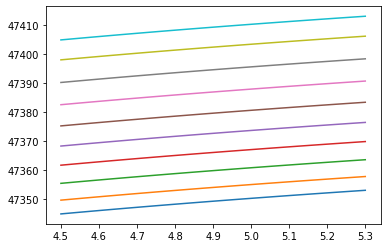

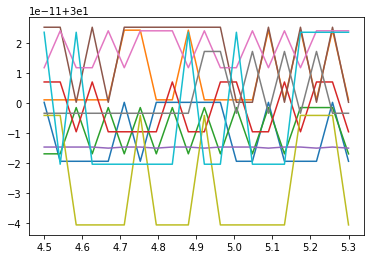

In [128]:
for i in range(Nϵ):
    plt.plot(Kgrid, Vp[:,i])
plt.show()

for i in range(Nϵ):
    plt.plot(Kgrid, Kp[:,i])
plt.show()

